### Imports

In [126]:
import numpy as np
import pandas as pd
import ace_tools_open as tools
from case_studies import *
import time
import matplotlib.pyplot as plt

In [127]:
#Save case study functions, their derivatives and hessians in lists
fs = [f1, f3, f4, f5]
dfs = [df1, df3, df4, df5]
Hfs = [Hf1, Hf3, Hf4, Hf5]
fnames = ["f1", "f3", "f4", "f5"]

In [128]:
def projected_gradient_norm(Q, b, x):
    grad = Q @ x + b
    x_norm_sq = np.dot(x, x)
    M = np.eye(len(x)) - np.outer(x, x) / x_norm_sq
    proj_grad = M @ grad
    return np.linalg.norm(proj_grad)

In [129]:

def alg12(Q, b, delta, epsilon):
    proj_grads = []
    stopping_criteria_list = []
    def p(lambd):
        return -np.linalg.inv(Q + lambd * np.identity(Q.shape[0])).dot(b)
    
    lambda1 = np.linalg.eigvalsh(Q)[0]
    

    if lambda1 > 0 and np.linalg.norm(p(0)) <= delta:
        return p(0), [0], [0]
    
    l = max(0, -lambda1)
    u = max(0, -lambda1) + 1
    
    while np.linalg.norm(p(u)) > delta:
        l = u
        u = 2 * u
    
    while True:
        lambdaMark = 0.5 * (l + u)
        pMark = p(lambdaMark)
        stopping_criteria_list.append(abs(np.linalg.norm(pMark) - delta))
        proj_grad = projected_gradient_norm(Q, b, pMark)
        proj_grads.append(proj_grad)

        if np.linalg.norm(pMark) < delta and abs(np.linalg.norm(pMark) - delta) < epsilon:
            return pMark, proj_grads, stopping_criteria_list
        
        if np.linalg.norm(pMark) > delta:
            l = lambdaMark
        else:
            u = lambdaMark


In [130]:
def generate_problem(n=5, Q_type='posdef', feasibility='feasible'):
    A = np.random.randn(n, n)
    Q = A.T @ A
    if Q_type == 'negdef':
        Q = -Q

    if feasibility == 'feasible':
        x_star = np.random.randn(n) * 0.5
        delta = np.linalg.norm(x_star) + 0.1
    elif feasibility == 'infeasible':
        x_star = np.random.randn(n) * 3.0
        delta = np.linalg.norm(x_star) * 0.7
    else:
        raise ValueError("feasibility must be 'feasible' or 'infeasible'")

    b = -Q @ x_star
    return Q, b, delta, x_star


In [131]:

def test_all_cases():
    results = []
    cases = [
        ('posdef', 'feasible'),
        ('posdef', 'infeasible'),
        ('negdef', 'feasible'),
        ('negdef', 'infeasible')
    ]

    for Q_type, feasibility in cases:
        Q, b, delta, x_star = generate_problem(n=5, Q_type=Q_type, feasibility=feasibility)
        x_sol, proj_grads, stopping_criteria_list = alg12(Q, b, delta, epsilon=1e-6)

        print(f"--- Q={Q_type}, feasibility={feasibility} ---")
        print(f"||x_star|| = {np.linalg.norm(x_star):.4f}")
        print(f"||x_sol||  = {np.linalg.norm(x_sol):.4f}")
        print(f"delta      = {delta:.4f}")
        if feasibility == 'feasible':
            print(f"Distance between x_star and x_sol: {np.linalg.norm(x_sol - x_star):.6f}")

        results.append((Q_type, feasibility, Q, b, delta, np.linalg.norm(x_star), np.linalg.norm(x_sol), proj_grads, proj_grads[-1], stopping_criteria_list, stopping_criteria_list[-1]))
    
    columns = ["Q_type", "Feasibility", "Q", "b", "delta", "||x_star||", "||x_sol||", "Projected Gradients", "Final Projected Gradient", "Progress", "Final"]

    df_results = pd.DataFrame(results, columns=columns)
    df_display = df_results.drop(columns=["Q", "b", "Projected Gradients", "Final Projected Gradient", "Progress"])

    return df_results, df_display


In [132]:
df_results, df_display = test_all_cases()
tools.display_dataframe_to_user(name="Benchmark Results", dataframe=df_display)

--- Q=posdef, feasibility=feasible ---
||x_star|| = 0.9510
||x_sol||  = 0.9510
delta      = 1.0510
Distance between x_star and x_sol: 0.000000
--- Q=posdef, feasibility=infeasible ---
||x_star|| = 5.5754
||x_sol||  = 3.9028
delta      = 3.9028
--- Q=negdef, feasibility=feasible ---
||x_star|| = 1.1269
||x_sol||  = 1.2269
delta      = 1.2269
Distance between x_star and x_sol: 2.167028
--- Q=negdef, feasibility=infeasible ---
||x_star|| = 7.8998
||x_sol||  = 5.5299
delta      = 5.5299
Benchmark Results


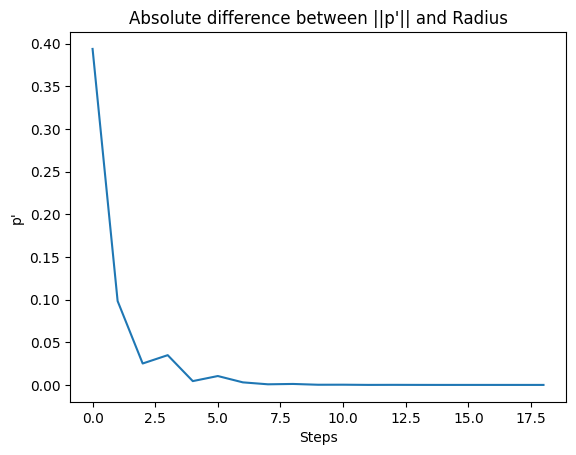

In [133]:
proj_grads_case2_1 = df_results["Progress"][1]
import matplotlib.pyplot as plt
plt.plot(proj_grads_case2_1)
plt.xlabel("Steps")
plt.ylabel("p'")
plt.title("Absolute difference between ||p'|| and Radius")
plt.show()

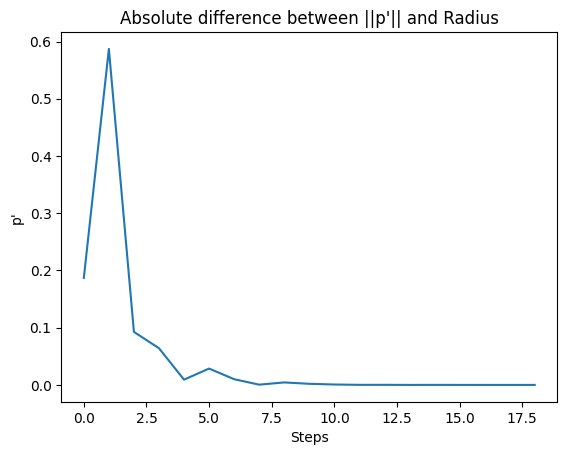

In [134]:
proj_grads_case2_2 = df_results["Progress"][2]
import matplotlib.pyplot as plt
plt.plot(proj_grads_case2_2)
plt.xlabel("Steps")
plt.ylabel("p'")
plt.title("Absolute difference between ||p'|| and Radius")
plt.show()

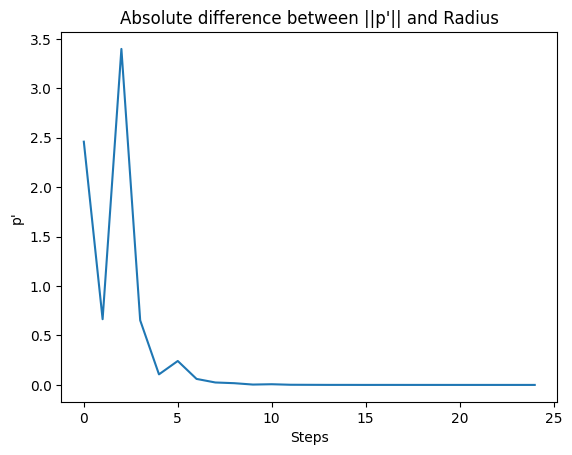

In [135]:
proj_grads_case2_3 = df_results["Progress"][3]
import matplotlib.pyplot as plt
plt.plot(proj_grads_case2_3)
plt.xlabel("Steps")
plt.ylabel("p'")
plt.title("Absolute difference between ||p'|| and Radius")
plt.show()